Model Definition

In [1]:
# import necessary packages
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt

import matplotlib.pyplot as plt
from utilities import *

from matplotlib.colors import LinearSegmentedColormap

from functools import reduce
from functools import partial

#   # Create a custom colormap that is inverted
cmap = plt.cm.viridis  # Choose the colormap you want to invert
cmap_inverted = LinearSegmentedColormap.from_list("inverted_viridis", cmap(np.linspace(1, 0, 256)))



from timeit import default_timer
import scipy.io
import os
import sys
from itertools import chain
import time



from TrainPlanningOperator3D import PlanningOperator3D, smooth_chi


In [2]:
print("Training Planning Operator")
os.chdir("/mountvol/dataset-80-igib")

lrs = [1e-2]
gammas = [0.5]
wds = [3e-6]
smooth_coefs = [5.]
smooth_coef = smooth_coefs[0]
# experiments to be replicated with different seeds
seeds = [5, 2000, 14000, 16000, 100000]
seeds = [seeds[0]]

################################################################
#                       configs
################################################################
Ntotal = 32*10+8*10
ntrain = 32*10
ntest =  8*10

batch_size = 1

epochs = 501
scheduler_step = 100
tol_early_stop = 500

modes = 5
width = 8
nlayers = 2

################################################################
# load data and data normalization
################################################################
t1 = default_timer()

sub = 1
Sx = int(((80 - 1) / sub) + 1)
Sy = Sx
Sz = int(((25 - 1) / sub) + 1)

mask = np.load('mask.npy')[:Ntotal,:,:,:]
mask = torch.tensor(mask, dtype=torch.float)
dist_in = np.load('dist_in.npy')[:Ntotal,:,:,:]
dist_in = torch.tensor(dist_in[:Ntotal, :, :], dtype=torch.float)
input = smooth_chi(mask, dist_in, smooth_coef)
output = np.load('output.npy')[:Ntotal,:,:,:]
output = torch.tensor(output, dtype=torch.float)

goals = np.load('goals.npy')[:Ntotal,:]
goals = torch.tensor(goals, dtype=torch.float)


mask_train = mask[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]

mask_train = mask_train.reshape(ntrain, Sx, Sy, Sz, 1)
mask_test = mask_test.reshape(ntest, Sx, Sy, Sz, 1)

chi_train = input[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
chi_test = input[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]

chi_train = chi_train.reshape(ntrain, Sx, Sy, Sz, 1)
chi_test = chi_test.reshape(ntest, Sx, Sy, Sz,1)

y_train = output[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
y_test = output[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]

y_train = y_train.reshape(ntrain, Sx, Sy, Sz, 1)
y_test = y_test.reshape(ntest, Sx, Sy, Sz, 1)

goals_train = goals[:ntrain]
goals_test = goals[-ntest:]

goals_train = goals_train.reshape(ntrain, 3, 1)
goals_test = goals_test.reshape(ntest, 3, 1)


# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_train, chi_train, y_train, goals_train),
#                                             batch_size=batch_size,
#                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                            batch_size=batch_size,
                                            shuffle=True)

Training Planning Operator


Loading the trained Model

In [3]:
# Load the trained model
model = PlanningOperator3D(modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("planningoperator_igibsonenv80_w8_l2_b10_lr1e-3_10g_17sep/n320_lr1.000000e-03_gamma8.000000e-01_wd3.000000e-06_seed5/model3d.ckpt"))
# model.load_state_dict(torch.load("planningoperator_3d_20x20x20_symmetric_norm/n10000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/tmp/ipykernel_23124/1845004880.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("planningoperator_igibsonenv80_w8_l2_b10_lr1e-3_10g_17se

PlanningOperator3D(
  (fc0): Linear(in_features=3, out_features=8, bias=True)
  (conv0): SpectralConv3d()
  (w0): Conv3d(8, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv1): SpectralConv3d()
  (w1): Conv3d(8, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=8, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Plot predicted and ground truth

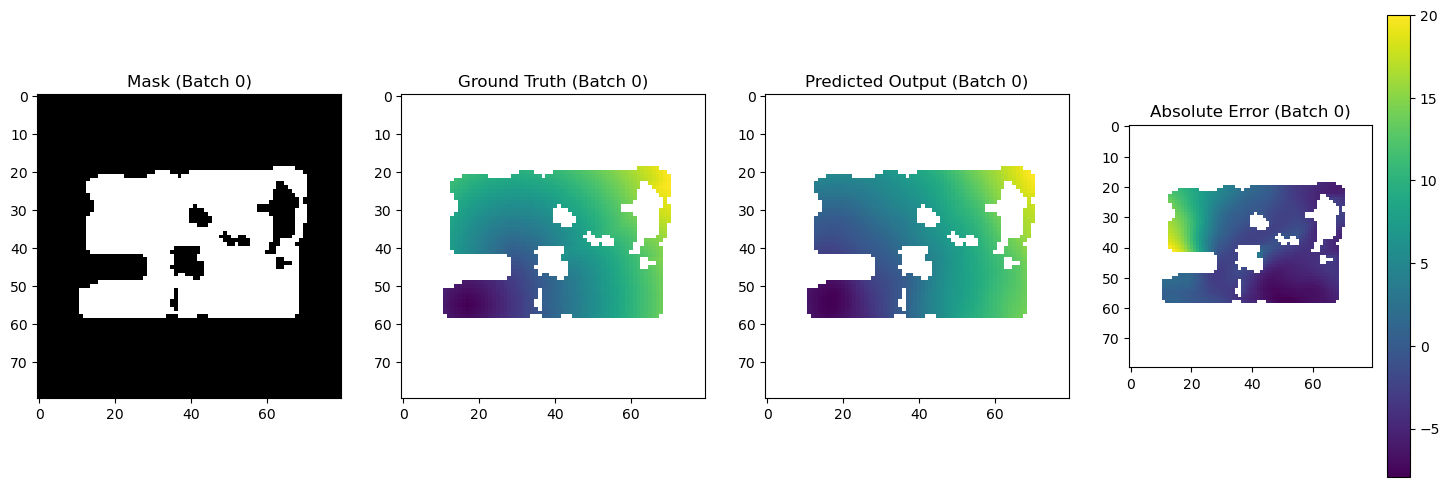

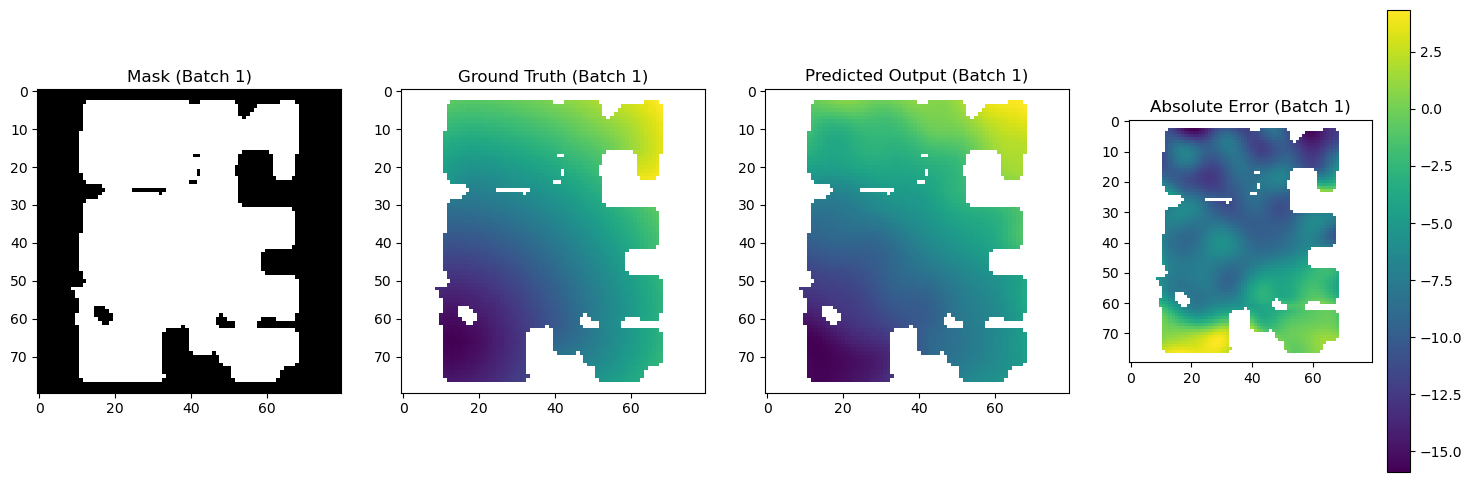

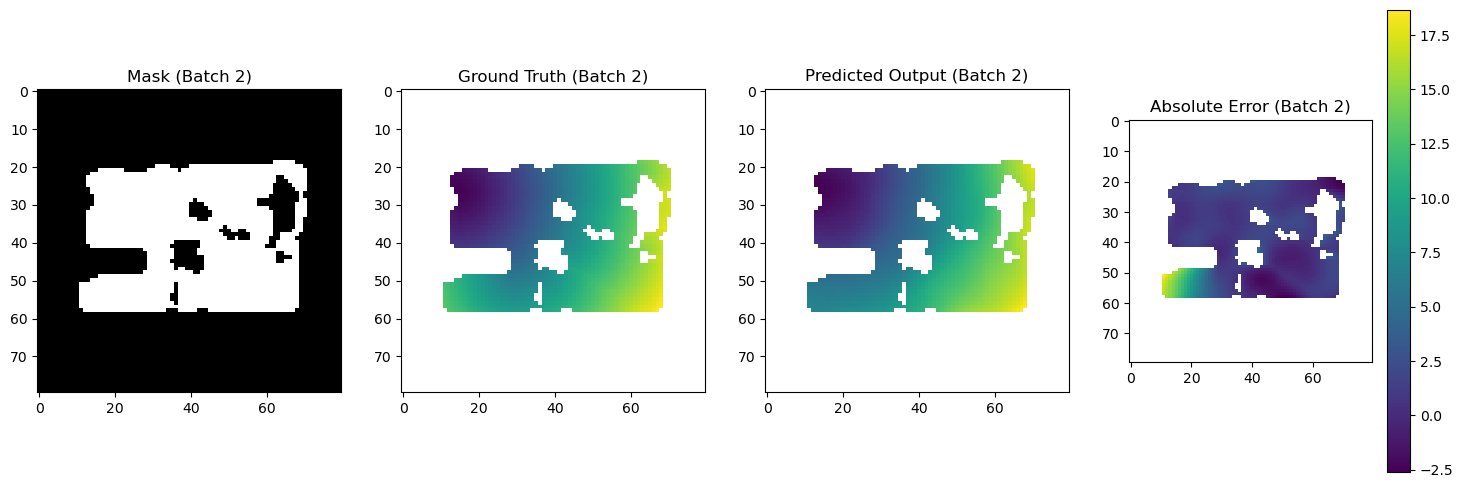

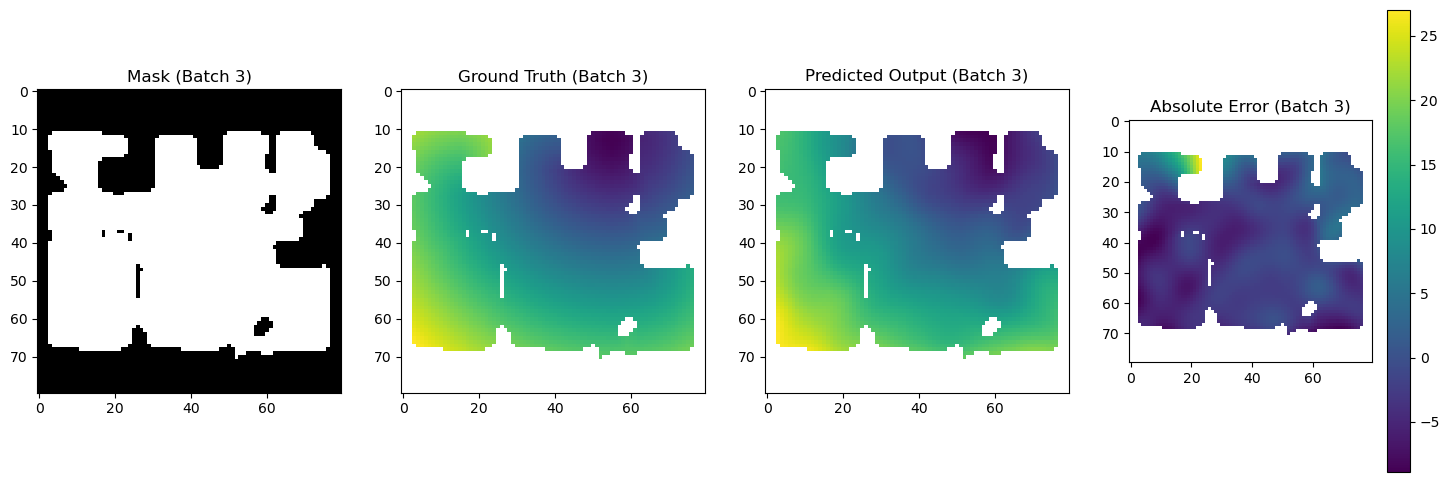

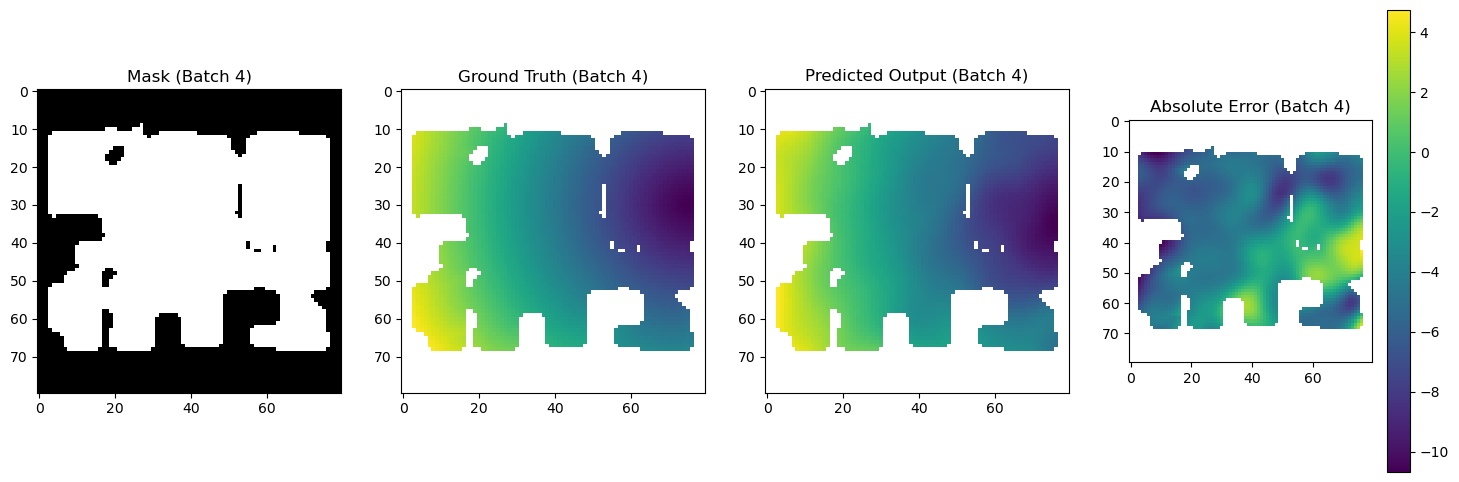

In [4]:
mean_error = 0
count = 0
normalization = 1/1.0  # Adjust or calculate as needed

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')).to(device), predicted_output)
        ground_truth = torch.where(mask == 0, torch.tensor(float('inf')).to(device), ground_truth)
        absolute_error = (ground_truth - predicted_output * normalization)

        # Set z dynamically as the third element of the goal's position
        z = gg[0, 2].item()  # Assuming gg contains goal coordinates and [0, 2] is the z-coordinate
        z = 12
        
        if batch_id == 5:
            break

        # Plot results for the current batch
        plt.figure(figsize=(18, 6))
        
        titles = ['Mask', 'Ground Truth', 'Predicted Output', 'Absolute Error']
        images = [
            mask[0, :, :, int(z), 0].cpu().numpy(),
            ground_truth[0, :, :, int(z), 0].cpu().numpy(),
            predicted_output[0, :, :, int(z), 0].cpu().numpy(),
            absolute_error[0, :, :, int(z), 0].cpu().numpy()
        ]
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(images[i], cmap='viridis' if i > 0 else 'gray')
            plt.title(f'{titles[i]} (Batch {batch_id})')
            if i == 3:
                plt.colorbar()
        plt.show()

In [9]:
#Gradient Descent Function

# Primary movements in 3D: forward, backward, left, right, up, down
primary_moves = [
    [-1., 0., 0.],  # left
    [1., 0., 0.],   # right
    [0., 1., 0.],   # forward
    [0., -1., 0.],  # backward
    [0., 0., 1.],   # up
    [0., 0., -1.]   # down
]

# Diagonal movements in 3D
diagonal_moves = [
    [-1., 1., 0.],  # left-forward
    [-1., -1., 0.], # left-backward
    [1., 1., 0.],   # right-forward
    [1., -1., 0.],  # right-backward
    [-1., 0., 1.],  # left-up
    [-1., 0., -1.], # left-down
    [1., 0., 1.],   # right-up
    [1., 0., -1.],  # right-down
    [0., 1., 1.],   # forward-up
    [0., 1., -1.],  # forward-down
    [0., -1., 1.],  # backward-up
    [0., -1., -1.], # backward-down
    [-1., 1., 1.],  # left-forward-up
    [-1., 1., -1.], # left-forward-down
    [-1., -1., 1.], # left-backward-up
    [-1., -1., -1.],# left-backward-down
    [1., 1., 1.],   # right-forward-up
    [1., 1., -1.],  # right-forward-down
    [1., -1., 1.],  # right-backward-up
    [1., -1., -1.]  # right-backward-down
]

# Combine primary and diagonal moves
action_vecs = np.asarray(primary_moves + diagonal_moves)

def perform_gradient_descent(value_function, start_point, goal_point, plotsuccess=False, plotfails=False, learning_rate=1, num_steps=1000):
    # print("Start Position:",start_point)
    # print("Goal Position:", goal_point)
    path_length = 0
    path_points = [start_point.copy().astype(float)]
    visited_points = set()
    current_point = start_point.copy().astype(float)

    for step in range(num_steps):
        best_gradient = np.inf
        best_action = None

        for action in action_vecs:
            new_point = current_point + learning_rate * action
            new_point_indices = np.round(new_point).astype(int)
            x_index, y_index, z_index = new_point_indices

            if (0 <= x_index < value_function.shape[0] and 
                0 <= y_index < value_function.shape[1] and 
                0 <= z_index < value_function.shape[2] and 
                (x_index, y_index, z_index) not in visited_points):
                gradient = value_function[x_index, y_index, z_index]
                if gradient < best_gradient:
                    best_gradient = gradient
                    best_action = action

        if best_gradient > 100:
            if plotfails:
                print("Failed Path:")
                plot_path(value_function, path_points)
            return False, 0, visited_points  

        if best_action is not None:
            current_point += learning_rate * best_action
            path_length += np.linalg.norm(learning_rate * best_action)
            path_points.append(current_point.copy())
            visited_points.add(tuple(np.round(current_point).astype(int)))
            if np.array_equal(np.round(current_point).astype(int), np.round(goal_point).astype(int)):
                if plotsuccess:
                    print("Successful Path:")
                    plot_path(value_function, path_points)
                    visited_points.add(goal_point)
                return True, path_length, visited_points  # Success
        else:
            if plotfails:
                print("Failed Path:")
                plot_path(value_function, path_points)
            return False, 0, visited_points  # No valid action found
    if plotfails:
        print("Failed Path:")
        plot_path(value_function, path_points)
    return False, 0 ,visited_points 

def plot_path(value_function, path_points):
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    path_points = np.array(path_points)

    # Identify and plot points where value function is infinite
    inf_indices = np.where(np.isinf(value_function))

    # Identify the goal position
    goal = np.argwhere(value_function == 0)  # Assuming the goal is where value is zero
    goal_z = goal[0][2]  # Assuming you only have one goal for simplicity

    # Plot obstacles as translucent orange
    ax.scatter(inf_indices[0], inf_indices[1], inf_indices[2], 
               c=(1.0, 0.5, 0.0, 0.05), marker='o', label='Obstacles')  # RGBA: orange with 50% opacity

    # Plot the path in 3D
    ax.plot(path_points[:, 0], path_points[:, 1], path_points[:, 2], 'ro-', label='Path')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    # Plot a cross-section at goal z in 2D
    ax2 = fig.add_subplot(122)
    
    # Get indices where the z-coordinate matches the goal z
    cross_section_indices = np.where(path_points[:, 2] == goal_z)

    # Plot the path at the cross-section
    ax2.plot(path_points[cross_section_indices, 0], path_points[cross_section_indices, 1], 'ro-', label=f'Path at z={goal_z}')
    
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.legend()
    plt.show()




In [10]:
# Compare against classical Planners

nosuceesscount = 0
notime = 0
nopath = 0

fmmsuceesscount = 0
fmmtime = 0
fmmpath = 0

# astarsuccesscount = 0
# astartime = 0
# astarpath = 0

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device)[0,:,:,:,0].reshape(1,Sx,Sy,Sz,1), chi.to(device)[0,:,:,:,0].reshape(1,Sx,Sy,Sz,1), ground_truth.to(device)[0,:,:,:,0].reshape(1,Sx,Sy,Sz,1), gg.to(device)[0,:,0].reshape(1,3,1)
        goal_point = gg[0,:,0].cpu().numpy()
        
        start_point = np.array([40,40,int(goal_point[2])])
        
        # Neural Operator Planning
        # t1 = tic()
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
        value_function = predicted_output[0, :, :, :, 0].cpu().detach().numpy()
        success_po, pathlength_po, path  = perform_gradient_descent(value_function,start_point,goal_point,learning_rate=1)
        # dt = toc(t1)

        if(success_po):
            nosuceesscount+=1
            nopath+=pathlength_po

        value_function_fmm = ground_truth
        value_function_fmm = torch.where(mask == 0, torch.tensor(float('inf')), value_function_fmm)
        value_function_fmm = value_function_fmm[0, :, :, :, 0].cpu().detach().numpy()
        success_fmm, pathlength_fmm, _  = perform_gradient_descent(value_function_fmm,start_point,goal_point,learning_rate=1)
        # dt = toc(t1)

        if(success_fmm):
            fmmsuceesscount+=1
            fmmpath+=pathlength_fmm    

        if batch_id == 0:
            break    


print("Planning Operator\nPath Lenght",pathlength_po,
      "\nSuccess:",success_po)

print("\nFMM\nPath Lenght",pathlength_fmm,
        "\nSuccess:",success_fmm)


Planning Operator
Path Lenght 43.31565037161873 
Success: True

FMM
Path Lenght 33.84887792598799 
Success: True


In [11]:
goal_point

array([55., 67.,  9.], dtype=float32)

In [12]:
path

{(41, 41, 9),
 (42, 42, 9),
 (43, 43, 9),
 (44, 44, 9),
 (45, 45, 10),
 (46, 46, 10),
 (47, 47, 10),
 (48, 48, 9),
 (49, 49, 8),
 (50, 50, 7),
 (51, 51, 6),
 (52, 52, 6),
 (53, 53, 6),
 (53, 56, 5),
 (53, 57, 4),
 (54, 54, 7),
 (54, 55, 6),
 (54, 58, 2),
 (54, 58, 3),
 (55, 59, 2),
 (55, 60, 3),
 (55, 67, 9),
 (56, 61, 4),
 (56, 62, 5),
 (56, 66, 9),
 (57, 63, 6),
 (57, 65, 8),
 (58, 64, 7)}

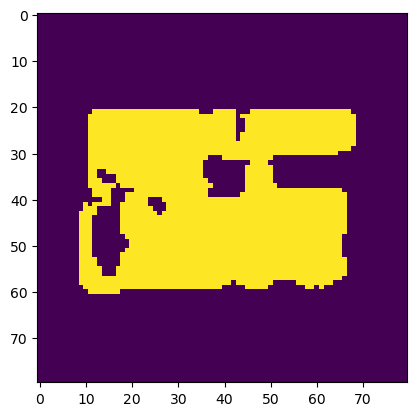

In [13]:
plt.imshow(mask[0,:,:,13,0].cpu().detach().numpy())